In [1]:
# import libraries
%matplotlib inline
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import datetime

In [2]:
df = pd.read_csv('anomalies.csv', index_col = False)

In [3]:
df[:3]

,Unnamed: 0,negative_spike,positive_spike,user_id,pos_cluster,neg_cluster,kernel_spike,kernel_cluster,normalized_review,time
0,0,"[Timestamp('2010-10-01 04:00:00'), Timestamp('...","[Timestamp('2008-11-01 04:00:00'), Timestamp('...",---1lKK3aKOuomHnwAkAow,"[0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 4, 4, 4]","[0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, ...","[Timestamp('2010-10-01 04:00:00'), Timestamp('...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...",[ 0. 0. 0. 0. ...,"[datetime.datetime(2008, 1, 1, 0, 0), datetime..."
1,1,"[Timestamp('2009-01-01 05:00:00'), Timestamp('...","[Timestamp('2009-07-01 04:00:00'), Timestamp('...",-0IiMAZI2SsQ7VmyzJjokQ,"[0, 0, 0, 0, 1, 2, 2, 2, 3, 4, 4, 4]","[0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, ...","[Timestamp('2009-07-01 04:00:00'), Timestamp('...","[0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3]",[ 0. 0. 0. 0. ...,"[datetime.datetime(2009, 1, 1, 0, 0), datetime..."
2,2,"[Timestamp('2010-01-01 05:00:00'), Timestamp('...","[Timestamp('2010-08-01 04:00:00'), Timestamp('...",-2UOdDlzg7XLuUuyOrldhA,"[0, 0, 0, 1, 1, 1, 1, 2]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]","[Timestamp('2010-08-01 04:00:00'), Timestamp('...","[0, 0, 0, 1, 1, 1, 2]",[ 0. 0. 0. 0. ...,"[datetime.datetime(2010, 1, 1, 0, 0), datetime..."


In [4]:
# create DataFrame
users=[]
with open('../../hduser1/Yelp/user.json') as json_file:
    for line in json_file:
        users.append(json.loads(line))
user_df = pd.DataFrame(users)

In [5]:
x = filter(lambda x: not len(x) == 0, df.iloc[0]['normalized_review'].split('[')[1].split(']')[0].split(' '))

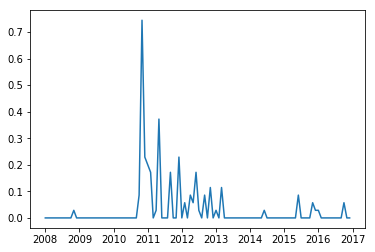

In [6]:
plt.plot(eval(df.iloc[0]['time']), [float(i) for i in x])

In [7]:
def DTWDistance(s1, s2,w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [8]:
y = filter(lambda x: not len(x) == 0, df.iloc[4]['normalized_review'].split('[')[1].split(']')[0].split(' '))

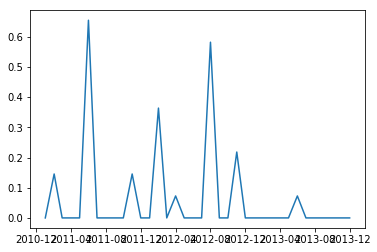

In [9]:
plt.plot(eval(df.iloc[4]['time']), [float(i) for i in y])

In [10]:
z = filter(lambda x: not len(x) == 0, df.iloc[2]['normalized_review'].split('[')[1].split(']')[0].split(' '))

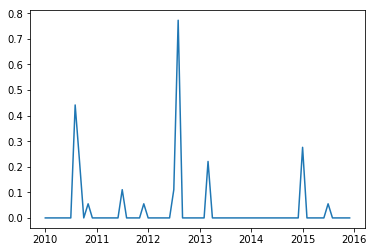

In [11]:
plt.plot(eval(df.iloc[2]['time']), [float(i) for i in z])

In [12]:
x = [float(i) for i in x]

In [13]:
y = [float(i) for i in y]

In [14]:
z = [float(i) for i in z]

In [15]:
DTWDistance(z,y,12)

0.53009407359413963

In [16]:
DTWDistance(x,y,12)

0.59599751751609265

In [17]:
DTWDistance(x,z,12)

0.59028533859345511

In [18]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [19]:
LB_Keogh(x,y,120)

0.08941927999999999

In [20]:
LB_Keogh(y,z,120)

0.0

In [21]:
LB_Keogh(z,x,120)

0.02894773000000006

In [22]:
import random

def k_means_clust(data,num_clust,num_iter,w=12):
    centroids=random.sample(data,num_clust)
    counter=0
    for n in range(num_iter):
        counter+=1
        print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,120)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum= clust_sum + data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
    
    return centroids

In [23]:
def preprocess(row):
    y = filter(lambda x: not len(x) == 0, row.split('[')[1].split(']')[0].split(' '))
    return [float(i) for i in y]

In [24]:
def getMedian(beg, end, time, review):
    temp = []
    while(beg < len(time) and time[beg] <= end):
        temp.append(review[beg])
        beg+=1
    temp.sort()
    return temp

In [25]:
def step_plot(time, spikes, k_c, review):
    step_plot = []
    current = 0
    while current < len(time):
        # if the current position is the head of spike then append 1 till the cluster ends,
        # move index to the end of spike and 
        # slice the array 
     
        if (not len(spikes) == 0 and time[current] == spikes[0]):
            label = k_c[0]
            index = 0
            
            # get when to end 
            while(not len(k_c) == 0 and index < len(k_c) and label == k_c[index]):
                index += 1
            try:
                end = spikes[index-1]
            except:
                end = spikes[0]
    
            med = getMedian(current, end, time, review)

            i = current
            while(i < len(time) and time[i] <= end):
                step_plot.append(np.mean(med))
#                 step_plot.append(1.0)
                i+=1
            if index == len(k_c):
                spikes = []
                k_c = []
            else:
                spikes = spikes[index:]
                k_c = k_c[index:]

            current = i
      
        # if the current position is not the head of spike then append 0 
        else:
            step_plot.append(0.0)
            current += 1
    return step_plot     

In [26]:
def get_step(user):
    k_c = eval(df.iloc[user]['kernel_cluster'])
    Uid = df.iloc[user]['user_id']
    test = df.iloc[user]['kernel_spike'].split('[')[1].split(']')[0].split(', ')
    dates = [i.split('Timestamp')[1].split('(')[1].split(')')[0].split(' ')[0].split('\'')[1] for i in test]
    spikes = [datetime.datetime.strptime(date, "%Y-%m-%d").date() for date in dates]
    spikes = [(ti.year, ti.month) for ti in spikes]
    if len(k_c) < len(spikes):
        k_c = []
        for i in range(len(spikes)):
            k_c.append(0)
    t = eval(df.iloc[user]['time'])
    time = [(time.year, time.month) for time in t]
    review = preprocess(df.iloc[user]['normalized_review'])
    x = filter(lambda x: not len(x) == 0, df.iloc[user]['normalized_review'].split('[')[1].split(']')[0].split(' '))
    y = step_plot(time, spikes, k_c, review)
#     plt.plot(t,x, alpha = 0.8)
#     plt.plot(t,y, alpha = 0.4)
    
    return Uid,t,y

In [27]:
y3 = get_step(661)

In [30]:
def SpliceData(idx):
    splice = []
    label = []
    u,t,y = get_step(idx)
    for year in range(len(y)/12-1):
        splice.append(y[year*12:year*12 + 24])
        current = str(t[year*12].year + 2)
        e,n,p,s = getStatus(u)
        if current in e:
            label.append(0)
        elif current in n:
            label.append(1)
        elif current in p:
            label.append(2)
        else:
            label.append(3)
    return splice, label

In [31]:
df.shape

(1605, 10)

In [33]:
# return the list of years when the user was 'elite', 'non', 'potential', 'slack'
def getStatus(uid):
    user = user_df.ix[user_df['user_id'] == uid]
    first = int(user['yelping_since'].values[0].split('-')[0]) + 1
    duration = 2017 - first
    slack = []
    elite = [] 
    potential = []
    non = []
    for i in range(duration):
        currentY = str(first + i) in user['elite'].values[0]
        nextY = str(first + i + 1) in user['elite'].values[0]

        if currentY and nextY:
            elite.append(str(first + i))
        elif currentY and not nextY:
            slack.append(str(first + i))
        elif not currentY and nextY:
            potential.append(str(first + i))
        elif not currentY and not nextY:
            non.append(str(first + i))
    return elite, non, potential, slack

In [ ]:
src = []
label = []
for i in range(df.shape[0]):
    if i % 100 == 0:
        print(i)
    s,l = SpliceData(i)
    src += s
    label += l

0


In [29]:
affinity = {}
for i in range(100):
    affinity[i] = {}
    if i%10==0:
            print(i)
    for j in range(i, 100):
        yi = get_step(i)        
        yj = get_step(j)
        affinity[i][j] = DTWDistance(yi,yj,60)        
        if affinity[i][j] == float('inf'):
            affinity[i][j] = DTWDistance(yj,yi,60)

0


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
mat = []
for i in affinity:
    ith = []
    for j in affinity:
        try:
            ith.append(affinity[i][j])
        except:
            ith.append(affinity[j][i])
    mat.append(ith)

In [ ]:
aff = np.matrix(mat)

In [43]:
from sklearn.cluster import DBSCAN
pred = DBSCAN(min_samples=2).fit_predict(aff)

In [64]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
dists = squareform(mat2)

In [65]:
Z = hierarchy.linkage(dists)

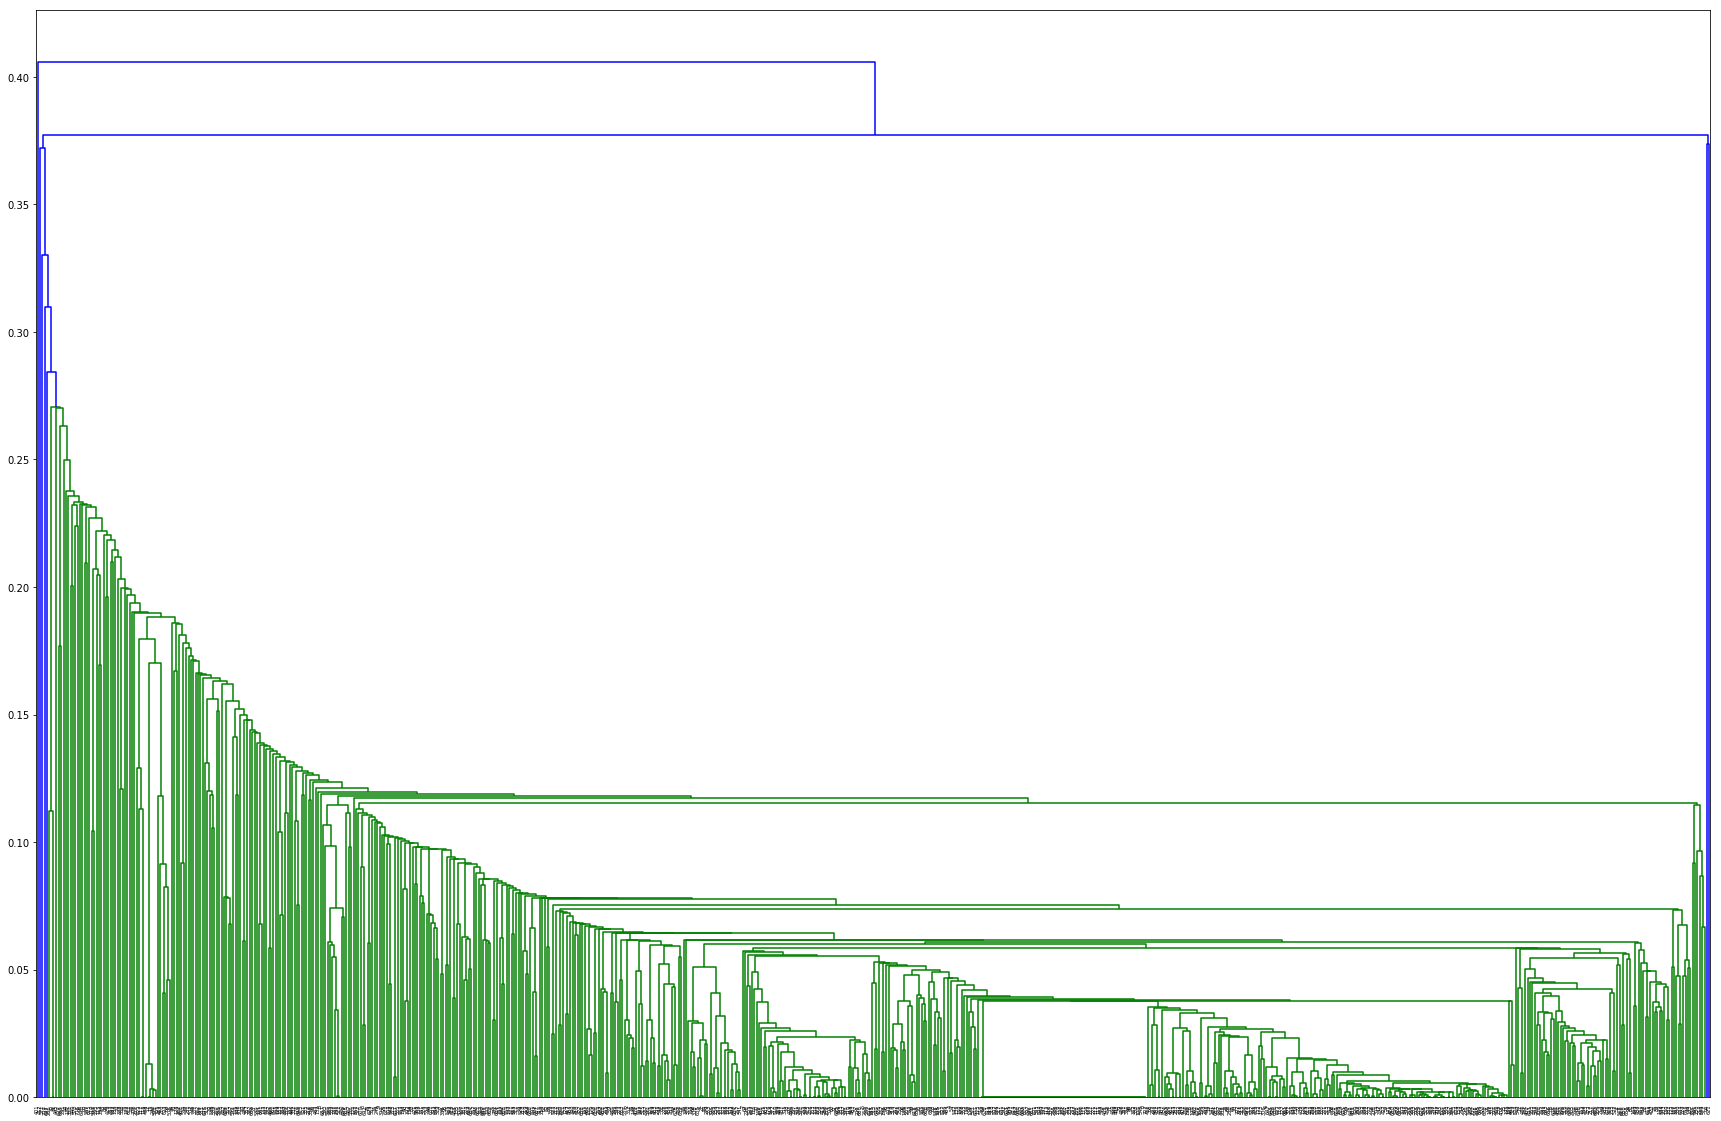

In [66]:
plt.figure(figsize = (30,20))
_ = hierarchy.dendrogram(Z)

In [189]:
from sklearn.cluster import SpectralClustering
cluster = 3
pred = SpectralClustering(cluster).fit_predict(mat2)

In [191]:
cluster_dict = {}
for i in range(cluster):
    cluster_dict[i] = []
for  i,p in enumerate(pred):
    cluster_dict[p].append(i)

In [152]:
affinity2 = {}
for i in range(100):
    affinity2[i] = {}
    if i%10==0:
            print(i)
    for j in range(i, 100):
        yi = get_step(i)        
        yj = get_step(j)
        affinity2[i][j] = DTWDistance(yi,yj,60)        
        if affinity2[i][j] == float('inf'):
            affinity2[i][j] = DTWDistance(yj,yi,60)

0
10
20
30
40
50
60
70
80
90


In [162]:
pred

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [190]:
pred

array([0, 0, 2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0,
       2, 1, 0, 0, 2, 2, 0, 0], dtype=int32)

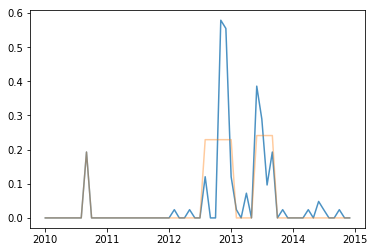

In [179]:
y = get_step(3)

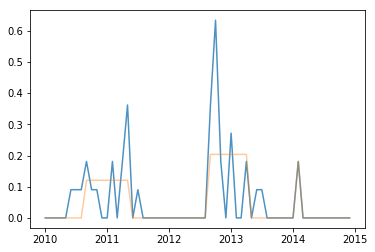

In [180]:
y = get_step(5)

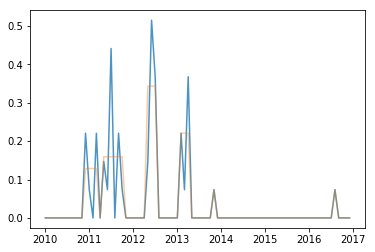

In [181]:
y = get_step(18)

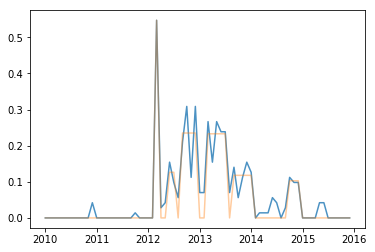

In [182]:
y = get_step(19)

In [33]:
u,t,y = get_step(5)

In [58]:
affinity2 = {}
for i in range(len(src)):
    affinity2[i] = {}
    if i%10==0:
            print(i)
    for j in range(i,len(src)):
#         yi = get_step(i)        
#         yj = get_step(j)
        affinity2[i][j] = DTWDistance(src[i],src[j],60)        
        if affinity2[i][j] == float('inf'):
            affinity2[i][j] = DTWDistance(src[j],src[i],60)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700


In [59]:
mat2 = []
for i in affinity2:
    ith = []
    for j in affinity2:
        try:
            ith.append(affinity2[i][j])
        except:
            ith.append(affinity2[j][i])
    mat2.append(ith)

In [62]:
aff = np.matrix(mat2)
pred = DBSCAN().fit_predict(aff)

In [63]:
pred

array([ 0, -1, -1, -1, -1, -1,  4, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  3,  0, -1, -1, -1, -1, -1, -1, -1,  0, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  4, -1,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,
        0,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  2, -1, -1, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0,  0, -1, -1, -1

In [155]:
c0 = 0
c1 = 0 
c2 = 0
c3 = 0
for i in label:
    if i == 0:
        c0 += 1
    elif i == 1:
        c1 += 1
    elif i == 2:
        c2 += 1
    else:
        c3 += 1

In [160]:
print('elite: {}, non: {}, potential: {}, slack: {}').format(c0, c1,c2,c3)

elite: 169, non: 142, potential: 36, slack: 135


In [287]:
c_weight = {}

c_weight[0] = float(c0)/float(len(label))
c_weight[1] = float(c1)/float(len(label))
c_weight[2] = float(c2)/float(len(label))
c_weight[3] = float(c3)/float(len(label))

In [161]:
from sklearn.model_selection import train_test_split

In [162]:
X_train, X_test, y_train, y_test = train_test_split(src, label, test_size=0.25)

In [165]:
from sklearn.neural_network import MLPClassifier

In [217]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(), random_state=1)

In [218]:
clf.fit(X_train, y_train) 

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(24, 12), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [219]:
pred = clf.predict(X_test)

In [220]:
clf.score(X_test, y_test) 

0.33884297520661155

In [224]:
High = 0
best = (0,0,0)
for i in range(24):
    print ('{}th iteration, best score: {}').format(i, High)
    for j in range(24):
        for k in range(24):
            clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(i+1, j+1, k+1), random_state=1)
            clf.fit(X_train, y_train) 
            score = clf.score(X_test, y_test)
            if score > High:
                High = score
                best = (i+1, j+1, k+1)

0th iteration, best score: 0
1th iteration, best score: 0.479338842975
2th iteration, best score: 0.495867768595
3th iteration, best score: 0.495867768595
4th iteration, best score: 0.495867768595
5th iteration, best score: 0.504132231405
6th iteration, best score: 0.504132231405
7th iteration, best score: 0.504132231405
8th iteration, best score: 0.504132231405
9th iteration, best score: 0.504132231405
10th iteration, best score: 0.512396694215
11th iteration, best score: 0.512396694215
12th iteration, best score: 0.512396694215
13th iteration, best score: 0.512396694215
14th iteration, best score: 0.512396694215
15th iteration, best score: 0.512396694215
16th iteration, best score: 0.512396694215
17th iteration, best score: 0.512396694215
18th iteration, best score: 0.512396694215
19th iteration, best score: 0.512396694215
20th iteration, best score: 0.512396694215
21th iteration, best score: 0.512396694215
22th iteration, best score: 0.512396694215
23th iteration, best score: 0.5123

In [225]:
best

(10, 24, 12)

In [228]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 24, 12), random_state=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [229]:
pred

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 0, 1, 3, 1, 0, 3, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 1, 1, 3, 0, 1, 3,
       3, 0, 1, 0, 3, 1, 1, 3, 0, 1, 0, 1, 1, 3, 1, 1, 3, 1, 3, 3, 0, 3, 3,
       0, 0, 3, 1, 1, 3, 3, 0, 3, 1, 0, 0, 1, 0, 3, 3, 1, 0, 1, 0, 0, 3, 0,
       0, 0, 3, 0, 1, 1, 3, 0, 3, 0, 1, 0, 3, 0, 0, 3, 0, 1, 3, 1, 3, 0, 1,
       3, 1, 3, 0, 1, 1])

In [232]:
pred

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 0, 1, 3, 1, 0, 3, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 1, 1, 3, 0, 1, 3,
       3, 0, 1, 0, 3, 1, 1, 3, 0, 1, 0, 1, 1, 3, 1, 1, 3, 1, 3, 3, 0, 3, 3,
       0, 0, 3, 1, 1, 3, 3, 0, 3, 1, 0, 0, 1, 0, 3, 3, 1, 0, 1, 0, 0, 3, 0,
       0, 0, 3, 0, 1, 1, 3, 0, 3, 0, 1, 0, 3, 0, 0, 3, 0, 1, 3, 1, 3, 0, 1,
       3, 1, 3, 0, 1, 1])

In [269]:
# change 3 to 1 and 2 to 0
fixed = []
for i in pred:
    if i == 3:
        fixed.append(1)
    elif i == 2:
        fixed.append(0)
    else:
        fixed.append(i)

In [270]:
fixed_y = []
for i in y_test:
    if i == 3:
        fixed_y.append(1)
    elif i == 2:
        fixed_y.append(0)
    else:
        fixed_y.append(i)

In [271]:
from sklearn.metrics import accuracy_score
accuracy_score(np.array(fixed), np.array(fixed_y))

0.61157024793388426

In [266]:
# change 3 to 1 and 2 to 0
fixed = []
for i in pred:
    if i == 3:
        fixed.append(0)
    elif i == 2:
        fixed.append(1)
    else:
        fixed.append(i)

In [267]:
fixed_y = []
for i in y_test:
    if i == 3:
        fixed_y.append(0)
    elif i == 2:
        fixed_y.append(1)
    else:
        fixed_y.append(i)

In [268]:
accuracy_score(np.array(fixed), np.array(fixed_y))

0.57024793388429751

In [247]:
from sklearn import svm

In [302]:
clf = svm.SVC()
clf.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [279]:
clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [257]:
from sklearn.neighbors import KNeighborsClassifier

In [258]:
neigh = KNeighborsClassifier(n_neighbors=3)

In [259]:
neigh.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [265]:
pred = neigh.predict(X_test)

In [264]:
accuracy_score(y_test, neigh.predict(X_test))

0.38016528925619836

In [272]:
from sklearn.naive_bayes import MultinomialNB

In [273]:
clf = MultinomialNB()

In [274]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [276]:
clf.score(X_test, y_test)

0.41322314049586778

In [303]:
from sklearn.tree import DecisionTreeRegressor

In [309]:
regr_1 = DecisionTreeRegressor(max_depth=5)

In [310]:
regr_1.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [323]:
regr_1.score(X_test, y_test)

-0.057381813806562043

In [324]:
from sklearn import ensemble

In [325]:
param = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,'learning_rate': 0.01, 'loss': 'ls'}

In [326]:
clf = ensemble.GradientBoostingRegressor(**param)

In [327]:
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [328]:
clf.score(X_test, y_test)

-0.03804631087142285